# Alzheimer’s Disease snRNA-seq Analysis (Entorhinal Cortex)

**Author:** Olivia Mohning  
**Repository:** `scrnaseq`  
**Notebook:** `notebooks/01_data_ingestion_and_eda.ipynb`  
**Created:** 2025-08-07  

This notebook uses single-nucleus RNA-sequencing (snRNA-seq) data from the entorhinal cortex of Alzheimer’s disease and control brains (dataset **GSE138852**) to perform exploratory data analysis in Python. The workflow focuses on reproducible data ingestion, cleaning, integration of metadata, and visualization using the pandas data stack.  

### Objectives
- Load and align single-nucleus RNA-seq count matrices with associated metadata  
- Inspect dataset structure and cell-type composition  
- Perform exploratory data analysis (EDA) of gene expression across cell types and disease conditions (AD vs Control)  
- Visualize expression of key genes (e.g., APOE, CLU, GFAP) to identify early transcriptional patterns related to neurodegeneration

**Data Source:** GSE138852 – Human entorhinal cortex nuclei from aged Alzheimer’s disease and control individuals (found here: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE138852)  
**Platform:** Illumina NextSeq 500  
**Notes:** Count and metadata files are stored in `data/GSE138852/` and loaded directly for simple cleaning, analysis, and visualization.

## Step 1: Import modules, set up directories, read in data

### Import modules, suppress warnings

In [113]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module=r"louvain")
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Auto-detect repo root by walking up from current dir

In [67]:
def find_repo_root(start = Path.cwd()):
    for p in [start] + list(start.parents):
        if (p / "notebooks").is_dir() and (p / "data").is_dir() and (p / "README.md").exists():
            return p
    raise FileNotFoundError("Could not locate repo root. Are you running inside the 'scrnaseq' repo?")

repo_root = find_repo_root()

### Define file paths for later use

In [ ]:
data_dir = repo_root / "data"               # Data directory with the following subdirectories
src_dir  = data_dir / "raw" / "GSE138852"   # Raw, unprocessed data lives here
proc_dir = data_dir / "processed"           # Processed data saved here
fig_dir  = repo_root / "figures"            # Data visualization figs saved here
res_dir  = repo_root / "results"            # Summary tables, analysis outputs

### Make sure output directories exist

In [69]:
for d in (proc_dir, fig_dir, res_dir):
    d.mkdir(parents=True, exist_ok=True)

### Assign variables to file paths for raw data

In [70]:
counts_path = src_dir / "GSE138852_counts.csv"
meta_path   = src_dir / "GSE138852_covariates.csv"

### Sanity checks for repo root and file paths

In [71]:
print("Repo root:", repo_root)
print("Counts path:", counts_path.exists(), counts_path)
print("Meta path:",   meta_path.exists(),   meta_path)

Repo root: /Users/oliviamohning/Documents/ds-portfolio/scrnaseq
Counts path: True /Users/oliviamohning/Documents/ds-portfolio/scrnaseq/data/raw/GSE138852/GSE138852_counts.csv
Meta path: True /Users/oliviamohning/Documents/ds-portfolio/scrnaseq/data/raw/GSE138852/GSE138852_covariates.csv


### Load raw data and quick sanity checks

In [72]:
# Load data
counts_df = pd.read_csv(counts_path, index_col=0)
meta_df   = pd.read_csv(meta_path, index_col=0)

# Quick checks
print("Counts shape:", counts_df.shape)
print("Metadata shape:", meta_df.shape)

Counts shape: (10850, 13214)
Metadata shape: (13214, 5)


## Step 2: Data Cleaning and Label Standardization

### Inspect first few rows of counts_df and meta_df

In [73]:
display(counts_df.head())
display(meta_df.head())

,AAACCTGGTAGAAAGG_AD5_AD6,AAACCTGGTAGCGATG_AD5_AD6,AAACCTGTCAGTCAGT_AD5_AD6,AAACCTGTCCAAACAC_AD5_AD6,AAACCTGTCCAGTATG_AD5_AD6,AAAGCAACATGGGAAC_AD5_AD6,AAAGCAAGTCGAATCT_AD5_AD6,AAAGCAAGTTTGTTGG_AD5_AD6,AAAGTAGGTAATCACC_AD5_AD6,AAAGTAGGTTCCACGG_AD5_AD6,...,TTTGGTTAGCCACGCT_AD1_AD2,TTTGGTTCAACTTGAC_AD1_AD2,TTTGGTTCAGCCTTTC_AD1_AD2,TTTGGTTCATCGGACC_AD1_AD2,TTTGGTTTCCCAGGTG_AD1_AD2,TTTGGTTTCCGTACAA_AD1_AD2,TTTGTCACAAGCCATT_AD1_AD2,TTTGTCAGTATAGGTA_AD1_AD2,TTTGTCATCCACTGGG_AD1_AD2,TTTGTCATCCGGGTGT_AD1_AD2
FO538757.2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
AP006222.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP5-857K21.4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
RP11-206L10.9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NOC2L,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


,oupSample.batchCond,oupSample.cellType,oupSample.cellType_batchCond,oupSample.subclustID,oupSample.subclustCond
AAACCTGGTAGAAAGG_AD5_AD6,AD,oligo,oligo_AD,o3,AD
AAACCTGGTAGCGATG_AD5_AD6,AD,oligo,oligo_AD,o3,AD
AAACCTGTCAGTCAGT_AD5_AD6,AD,oligo,oligo_AD,o3,AD
AAACCTGTCCAAACAC_AD5_AD6,AD,oligo,oligo_AD,o3,AD
AAACCTGTCCAGTATG_AD5_AD6,AD,oligo,oligo_AD,o3,AD


### Transpose rows and columns of counts_df so nuclei are rows and genes are columns, to match meta_df

In [74]:
counts_df = counts_df.T
display(counts_df.head())

,FO538757.2,AP006222.2,RP5-857K21.4,RP11-206L10.9,NOC2L,HES4,ISG15,AGRN,C1orf159,SDF4,...,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-CYB,AL592183.1,AC007325.4,AC007325.2
AAACCTGGTAGAAAGG_AD5_AD6,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
AAACCTGGTAGCGATG_AD5_AD6,0,0,0,0,0,0,0,0,0,0,...,3,2,4,0,6,0,0,0,0,0
AAACCTGTCAGTCAGT_AD5_AD6,0,0,0,0,0,0,0,0,0,0,...,0,3,3,0,2,1,1,1,0,0
AAACCTGTCCAAACAC_AD5_AD6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
AAACCTGTCCAGTATG_AD5_AD6,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


### Keep only nuclei that exist in both counts and metadata

In [75]:
common_nuclei = counts_df.index.intersection(meta_df.index)
counts_df = counts_df.loc[common_nuclei]
meta_df = meta_df.loc[common_nuclei]

### Merge counts and metadata side by side, sanity checks, and previewing data

In [76]:
# Merge meta_df and counts_df
merged_df = pd.concat([meta_df, counts_df], axis=1)

# Basic sanity checks
print("Merged shape (cells x [metadata + genes]):", merged_df.shape)
print("Metadata columns:", list(meta_df.columns))
print("Gene columns (first 5):", list(counts_df.columns[:5]))
print("First 3 cell IDs:", merged_df.index[:3].tolist())

# Previewing data
merged_df.head()

Merged shape (cells x [metadata + genes]): (13214, 10855)
Metadata columns: ['oupSample.batchCond', 'oupSample.cellType', 'oupSample.cellType_batchCond', 'oupSample.subclustID', 'oupSample.subclustCond']
Gene columns (first 5): ['FO538757.2', 'AP006222.2', 'RP5-857K21.4', 'RP11-206L10.9', 'NOC2L']
First 3 cell IDs: ['AAACCTGGTAGAAAGG_AD5_AD6', 'AAACCTGGTAGCGATG_AD5_AD6', 'AAACCTGTCAGTCAGT_AD5_AD6']


,oupSample.batchCond,oupSample.cellType,oupSample.cellType_batchCond,oupSample.subclustID,oupSample.subclustCond,FO538757.2,AP006222.2,RP5-857K21.4,RP11-206L10.9,NOC2L,...,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-CYB,AL592183.1,AC007325.4,AC007325.2
AAACCTGGTAGAAAGG_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
AAACCTGGTAGCGATG_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0,0,0,0,...,3,2,4,0,6,0,0,0,0,0
AAACCTGTCAGTCAGT_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0,0,0,0,...,0,3,3,0,2,1,1,1,0,0
AAACCTGTCCAAACAC_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
AAACCTGTCCAGTATG_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


### Renaming metadata columns for readability

In [77]:
merged_df.rename(columns={
    'oupSample.batchCond': 'condition',
    'oupSample.cellType': 'cell_type',
    'oupSample.cellType_batchCond': 'celltype_condition',
    'oupSample.subclustID': 'subcluster_id',
    'oupSample.subclustCond': 'subcluster_condition'
}, inplace=True)

merged_df.head()

,condition,cell_type,celltype_condition,subcluster_id,subcluster_condition,FO538757.2,AP006222.2,RP5-857K21.4,RP11-206L10.9,NOC2L,...,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-CYB,AL592183.1,AC007325.4,AC007325.2
AAACCTGGTAGAAAGG_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
AAACCTGGTAGCGATG_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0,0,0,0,...,3,2,4,0,6,0,0,0,0,0
AAACCTGTCAGTCAGT_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0,0,0,0,...,0,3,3,0,2,1,1,1,0,0
AAACCTGTCCAAACAC_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
AAACCTGTCCAGTATG_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


### Cleaning data for readability and checking value counts of condition, cell_type, celltype_condition, subcluster_id, and subcluster_condition

In [78]:
# Renaming condition values for readability
merged_df['condition'] = merged_df['condition'].replace({'ct': 'Control', 'AD': 'Alzheimer'})
merged_df['condition'].value_counts()

condition
Alzheimer    6673
Control      6541
Name: count, dtype: int64

In [79]:
# Renaming celltype values for readability
merged_df['cell_type'] = merged_df['cell_type'].replace({
    'astro': 'Astrocyte',
    'oligo': 'Oligodendrocyte',
    'OPC': 'Oligodendrocyte Progenitor Cell',
    'mg': 'Microglia',
    'neuron': 'Neuron',
    'endo': 'Endothelial Cell',
    'unID': 'Unidentified Cell',
    'doublet': 'Doublet (Potential Artifact)'
})

merged_df['cell_type'].value_counts()

cell_type
Oligodendrocyte                    7432
Astrocyte                          2171
Oligodendrocyte Progenitor Cell    1078
Unidentified Cell                   925
Neuron                              656
Microglia                           449
Doublet (Potential Artifact)        405
Endothelial Cell                     98
Name: count, dtype: int64

In [80]:
# Renaming celltype_condition values for readability
merged_df['celltype_condition'] = merged_df['celltype_condition'].replace({
    'oligo_AD': 'Oligodendrocyte (Alzheimer)',
    'oligo_ct': 'Oligodendrocyte (Control)',
    'astro_AD': 'Astrocyte (Alzheimer)',
    'astro_ct': 'Astrocyte (Control)',
    'OPC_AD': 'Oligodendrocyte Progenitor Cell (Alzheimer)',
    'OPC_ct': 'Oligodendrocyte Progenitor Cell (Control)',
    'mg_AD': 'Microglia (Alzheimer)',
    'mg_ct': 'Microglia (Control)',
    'neuron_AD': 'Neuron (Alzheimer)',
    'neuron_ct': 'Neuron (Control)',
    'endo_AD': 'Endothelial Cell (Alzheimer)',
    'endo_ct': 'Endothelial Cell (Control)',
    'unID_AD': 'Unidentified Cell (Alzheimer)',
    'unID_ct': 'Unidentified Cell (Control)',
    'doublet_AD': 'Doublet (Potential Artifact, Alzheimer)',
    'doublet_ct': 'Doublet (Potential Artifact, Control)'
})

merged_df['celltype_condition'].value_counts()

celltype_condition
Oligodendrocyte (Alzheimer)                    4655
Oligodendrocyte (Control)                      2777
Astrocyte (Control)                            1699
Oligodendrocyte Progenitor Cell (Control)       899
Unidentified Cell (Alzheimer)                   614
Astrocyte (Alzheimer)                           472
Neuron (Control)                                407
Unidentified Cell (Control)                     311
Doublet (Potential Artifact, Alzheimer)         295
Microglia (Control)                             277
Neuron (Alzheimer)                              249
Oligodendrocyte Progenitor Cell (Alzheimer)     179
Microglia (Alzheimer)                           172
Doublet (Potential Artifact, Control)           110
Endothelial Cell (Control)                       61
Endothelial Cell (Alzheimer)                     37
Name: count, dtype: int64

In [81]:
# Rename subcluster_id to readable biological labels
prefix_map = {
    'a': 'Astrocyte Subcluster ',
    'o': 'Oligodendrocyte Subcluster ',
    'O': 'Oligodendrocyte Subcluster ',
    'n': 'Neuron Subcluster ',
    'm': 'Microglia Subcluster ',
    'e': 'Endothelial Subcluster ',
    'd': 'Doublet Subcluster ',
    'u': 'Unidentified Subcluster '
}

merged_df['subcluster_id'] = merged_df['subcluster_id'].apply(
    lambda x: prefix_map.get(x[0], 'Unknown Subcluster ') + x[1:] if isinstance(x, str) else x
)

merged_df['subcluster_id'].value_counts()

subcluster_id
Oligodendrocyte Subcluster 2    2279
Oligodendrocyte Subcluster 1    2052
Oligodendrocyte Subcluster 6    1902
Oligodendrocyte Subcluster 3     876
Oligodendrocyte Subcluster 5     827
Astrocyte Subcluster 5           600
Oligodendrocyte Subcluster 4     574
Astrocyte Subcluster 7           447
Astrocyte Subcluster 3           262
Unidentified Subcluster 7        256
Astrocyte Subcluster 1           222
Astrocyte Subcluster 2           219
Astrocyte Subcluster 8           207
Neuron Subcluster 5              192
Unidentified Subcluster 4        187
Microglia Subcluster 3           163
Unidentified Subcluster 3        148
Astrocyte Subcluster 4           146
Neuron Subcluster 3              127
Unidentified Subcluster 6        121
Doublet Subcluster 2             118
Microglia Subcluster 2           104
Neuron Subcluster 1              103
Doublet Subcluster 4              94
Doublet Subcluster 1              93
Neuron Subcluster 4               90
Neuron Subcluster 6     

In [86]:
# Renaming subcluster_condition values for readability
merged_df['subcluster_condition'] = merged_df['subcluster_condition'].replace({
    'ct': 'Control', 'AD': 'Alzheimer'})

merged_df['subcluster_condition'].value_counts()

subcluster_condition
Alzheimer       6440
Control         6050
undetermined     724
Name: count, dtype: int64

### Save cleaned dataset to proc_dir ("processed directory"), created earlier

In [88]:
processed_path = proc_dir / "01_processed_snrna_data.csv"
merged_df.to_csv(processed_path, index=True)
print(f"Saved processed dataset to: {processed_path}")


Saved processed dataset to: /Users/oliviamohning/Documents/ds-portfolio/scrnaseq/data/processed/01_processed_snrna_data.csv


## Step 3: Exploratory Data Analysis (EDA)

In [104]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13214 entries, AAACCTGGTAGAAAGG_AD5_AD6 to TTTGTCATCCGGGTGT_AD1_AD2
Columns: 10855 entries, condition to AC007325.2
dtypes: int64(10850), object(5)
memory usage: 1.1+ GB


In [ ]:
merged_df.describe()

,FO538757.2,AP006222.2,RP5-857K21.4,RP11-206L10.9,NOC2L,HES4,ISG15,AGRN,C1orf159,SDF4,...,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-CYB,AL592183.1,AC007325.4,AC007325.2
count,13214.000000,13214.000000,13214.000000,13214.000000,13214.000000,13214.000000,13214.000000,13214.000000,13214.000000,13214.000000,...,13214.000000,13214.000000,13214.000000,13214.000000,13214.000000,13214.000000,13214.000000,13214.000000,13214.000000,13214.000000
mean,0.134781,0.028379,0.130241,0.028606,0.034282,0.031709,0.021946,0.044877,0.033449,0.057666,...,0.379295,0.702134,0.324429,0.046542,0.791358,0.064401,0.417209,0.116392,0.023082,0.016952
std,0.381094,0.176230,0.376689,0.175979,0.188497,0.188946,0.176933,0.214227,0.187640,0.245146,...,0.910220,1.421729,0.824407,0.237672,1.601950,0.278957,0.975400,0.353485,0.154148,0.138704
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,5.000000,4.000000,4.000000,3.000000,2.000000,4.000000,6.000000,3.000000,4.000000,3.000000,...,18.000000,30.000000,12.000000,4.000000,37.000000,5.000000,18.000000,4.000000,2.000000,3.000000


### Checking for NAs

In [ ]:
merged_df.isna().sum().sort_values(ascending=False).head(10)

condition        0
DPY19L2          0
AVIL             0
LRIG3            0
SLC16A7          0
FAM19A2          0
USP15            0
MON2             0
RP11-631N16.2    0
PPM1H            0
dtype: int64

Saved: /Users/oliviamohning/Documents/ds-portfolio/scrnaseq/figures/condition_distribution.png


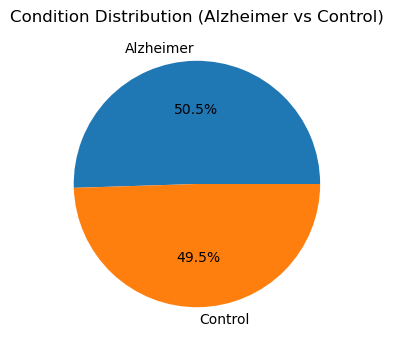

In [118]:
# Condition distribution
merged_df['condition'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('Condition Distribution (Alzheimer vs Control)')
plt.ylabel('')

# Save figure to figures folder
fig_path = fig_dir / "condition_distribution.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"Saved: {fig_path}")

plt.show()

Saved: /Users/oliviamohning/Documents/ds-portfolio/scrnaseq/figures/celltype_distribution.png


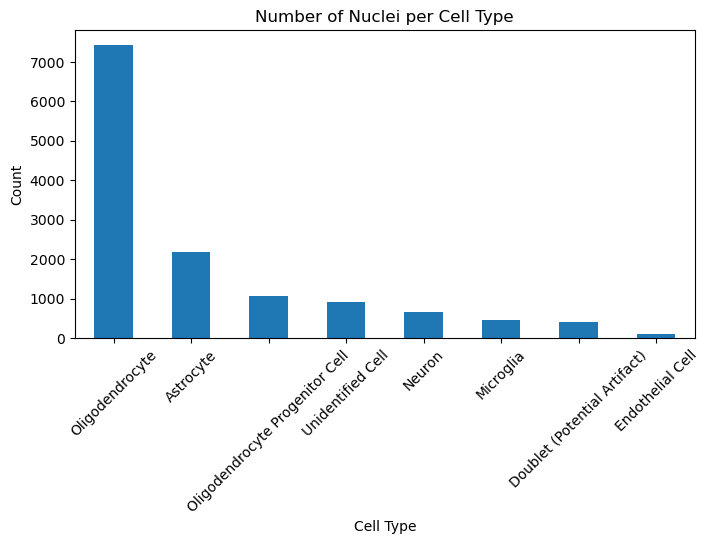

In [119]:
# Cell type distribution
merged_df['cell_type'].value_counts().plot(kind='bar', figsize=(8,4))
plt.title('Number of Nuclei per Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Save figure to figures folder
fig_path = fig_dir / "celltype_distribution.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"Saved: {fig_path}")

plt.show()

Saved: /Users/oliviamohning/Documents/ds-portfolio/scrnaseq/figures/celltype_composition_by_condition.png


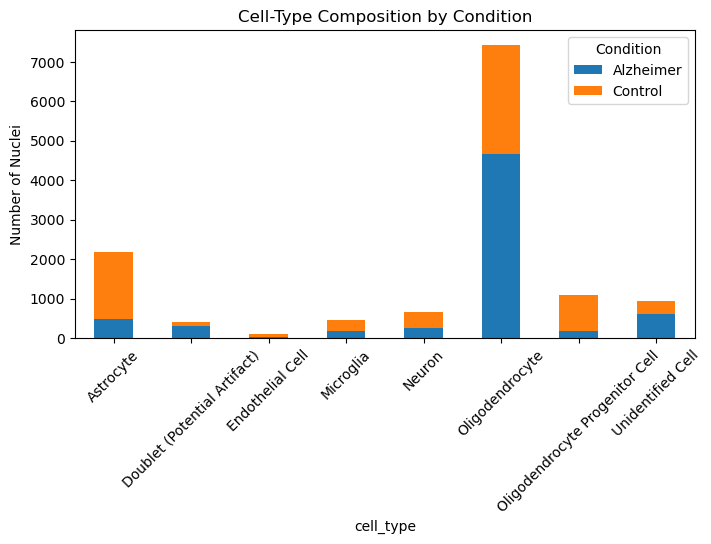

In [120]:
# Cell type by condition
summary_table = merged_df.groupby(['cell_type', 'condition']).size().unstack(fill_value=0)
summary_table.plot(kind='bar', stacked=True, figsize=(8,4))
plt.title('Cell-Type Composition by Condition')
plt.ylabel('Number of Nuclei')
plt.xticks(rotation=45)
plt.legend(title='Condition')

# Save figure to figures folder
fig_path = fig_dir / "celltype_composition_by_condition.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"Saved: {fig_path}")

plt.show()

Saved: /Users/oliviamohning/Documents/ds-portfolio/scrnaseq/figures/total_expression_distribution.png


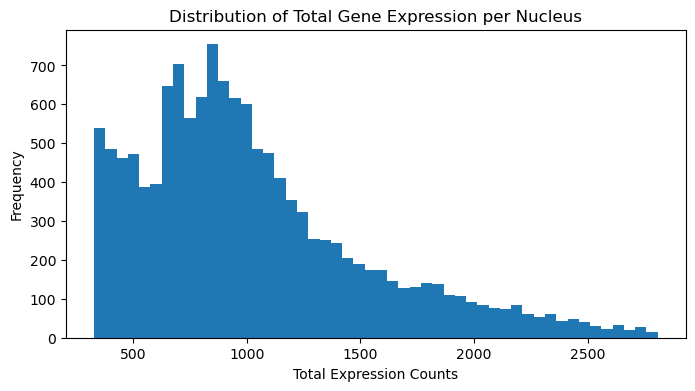

In [121]:
# Distribution of total expression per nucleus
merged_df.iloc[:, 5:].sum(axis=1).plot(kind='hist', bins=50, figsize=(8,4))
plt.title('Distribution of Total Gene Expression per Nucleus')
plt.xlabel('Total Expression Counts')
plt.ylabel('Frequency')

# Save figure to figures folder
fig_path = fig_dir / "total_expression_distribution.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"Saved: {fig_path}")

plt.show()

In [111]:
# Mean expression by cell type
celltype_means = merged_df.groupby('cell_type').mean(numeric_only=True)
celltype_means.head()

,FO538757.2,AP006222.2,RP5-857K21.4,RP11-206L10.9,NOC2L,HES4,ISG15,AGRN,C1orf159,SDF4,...,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-CYB,AL592183.1,AC007325.4,AC007325.2
cell_type,,,,,,,,,,,,,,,,,,,,,
Astrocyte,0.183326,0.047904,0.221557,0.032243,0.041916,0.094887,0.033625,0.053892,0.054353,0.071396,...,0.323814,0.614463,0.320129,0.049747,0.720405,0.074620,0.376785,0.122064,0.025795,0.085214
Doublet (Potential Artifact),0.150617,0.037037,0.120988,0.019753,0.049383,0.024691,0.056790,0.076543,0.034568,0.091358,...,0.933333,1.733333,0.617284,0.083951,1.646914,0.143210,0.829630,0.133333,0.032099,0.012346
Endothelial Cell,0.132653,0.040816,0.132653,0.051020,0.040816,0.295918,0.081633,0.122449,0.020408,0.051020,...,0.714286,1.285714,0.816327,0.091837,1.132653,0.112245,0.734694,0.122449,0.030612,0.010204
Microglia,0.089087,0.026726,0.102450,0.022272,0.024499,0.002227,0.013363,0.013363,0.020045,0.040089,...,0.207127,0.398664,0.178174,0.028953,0.447661,0.028953,0.256125,0.095768,0.006682,0.000000
Neuron,0.225610,0.035061,0.146341,0.051829,0.068598,0.053354,0.027439,0.042683,0.053354,0.097561,...,0.797256,1.855183,0.736280,0.103659,1.777439,0.128049,0.891768,0.143293,0.024390,0.003049


In [ ]:
# Save summary for reproducibility
celltype_means.to_csv(res_dir / 'mean_expression_by_celltype.csv')

Saved: /Users/oliviamohning/Documents/ds-portfolio/scrnaseq/figures/APOE_expression_by_celltype.png


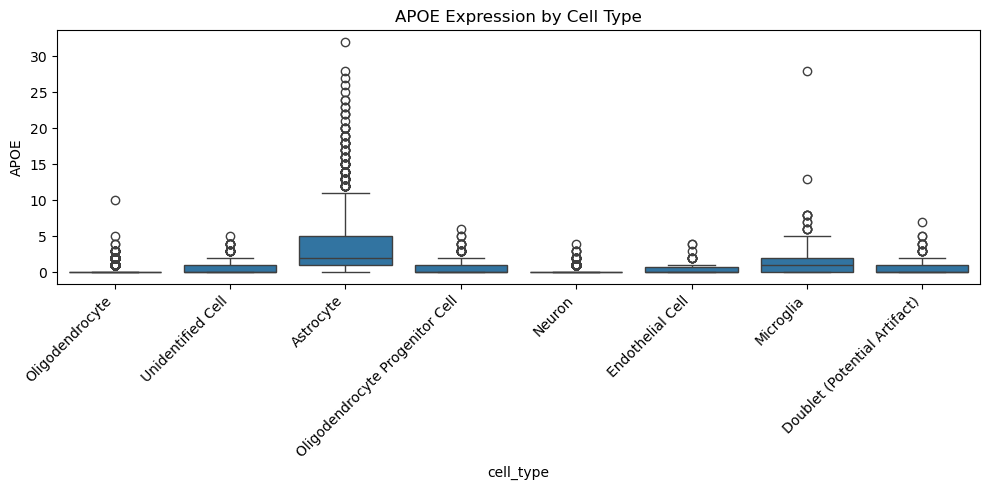

Saved: /Users/oliviamohning/Documents/ds-portfolio/scrnaseq/figures/CLU_expression_by_celltype.png


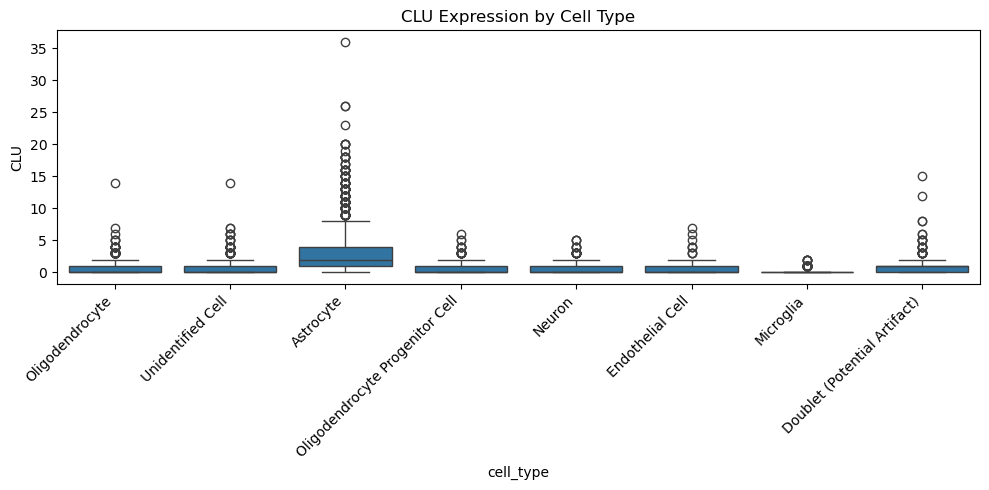

Saved: /Users/oliviamohning/Documents/ds-portfolio/scrnaseq/figures/GFAP_expression_by_celltype.png


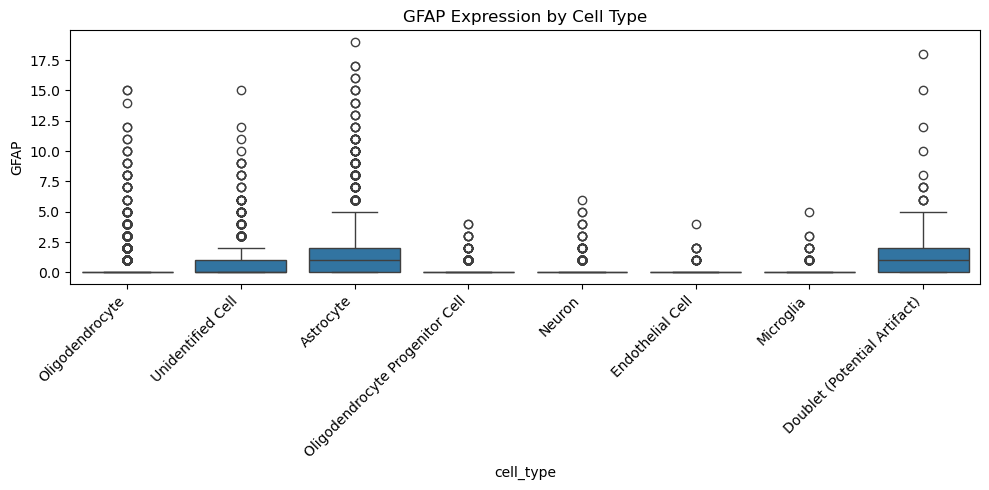

In [122]:
genes_of_interest = ['APOE', 'CLU', 'GFAP']

# Expression by cell type
for gene in genes_of_interest:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='cell_type', y=gene, data=merged_df)
    plt.title(f'{gene} Expression by Cell Type')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Save figure to figures folder
    fig_path = fig_dir / f"{gene}_expression_by_celltype.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {fig_path}")

    plt.show()

Saved: /Users/oliviamohning/Documents/ds-portfolio/scrnaseq/figures/APOE_expression_by_condition.png


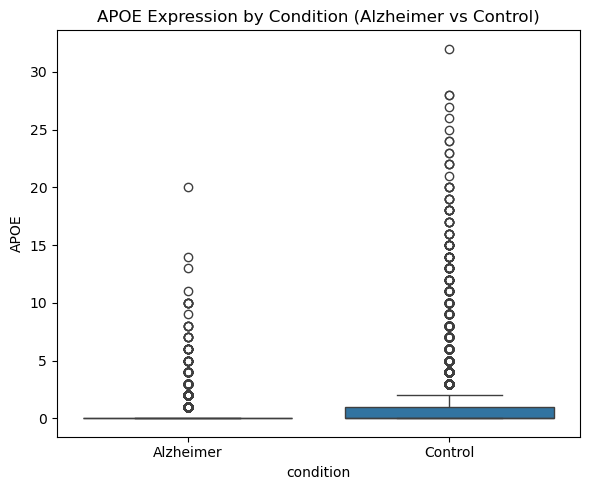

Saved: /Users/oliviamohning/Documents/ds-portfolio/scrnaseq/figures/CLU_expression_by_condition.png


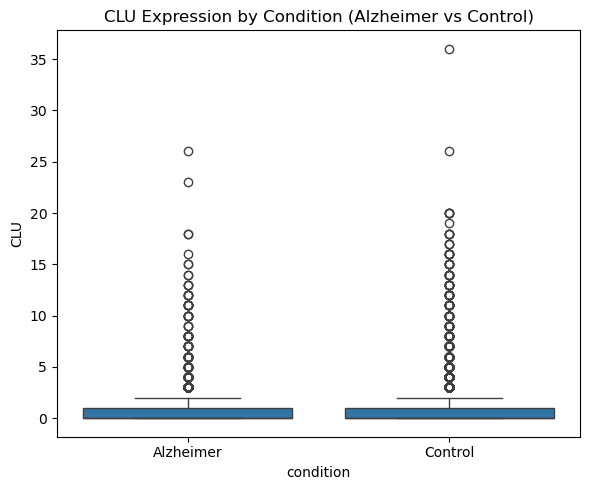

Saved: /Users/oliviamohning/Documents/ds-portfolio/scrnaseq/figures/GFAP_expression_by_condition.png


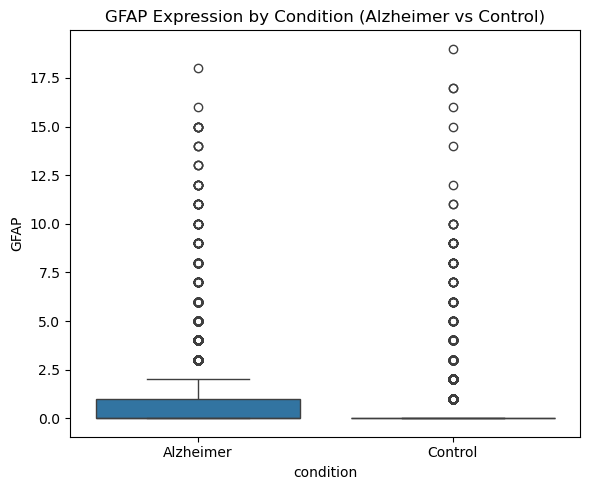

In [123]:
# Expression by condition
for gene in genes_of_interest:
    plt.figure(figsize=(6, 5))
    sns.boxplot(x='condition', y=gene, data=merged_df)
    plt.title(f'{gene} Expression by Condition (Alzheimer vs Control)')
    plt.tight_layout()

    # Save figure to figures folder
    fig_path = fig_dir / f"{gene}_expression_by_condition.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {fig_path}")

    plt.show()